# Sarsa(𝜆) 

Instead of using a one-step bootstrapping target, it uses the 𝜆-return

In [2]:
import random
import numpy as np
        
class SlipperyWalk:
    def __init__(self):
        self.reset()

    def reset(self):
        self.observation_space = 9
        self.action_space = 2
        self._state = np.random.choice([1,2,3,4,5,6,7])
        self._done = False
        return self._state

    def step(self, action):
        if self._done: raise ValueError('Episode has terminated')
        if action not in [0, 1]: raise ValueError('Invalid action')
        
        if(action==0): direction = -1
        if(action==1): direction = 1
        
        direction_list = [direction, -direction, 0]
        true_direction = random.choices(direction_list, weights=(50, 17, 33), k=1)
        self._state += true_direction[0]
        
        reward = 0
        if self._state < 1: self._done = True
        if self._state > 7: self._done = True; reward = 1
        return self._state, reward, self._done, 0  # obs, rew, done

In [3]:
slippery_walk = SlipperyWalk()

In [4]:
optimal_V = [0., 0.5637, 0.763, 0.8449, 0.8892, 0.922, 0.9515, 0.9806, 0.]  

In [5]:
def decay_schedule(init_value, min_value, decay_steps, max_steps):
    rem_steps = max_steps - decay_steps
    values = np.logspace(start=0, stop=-2, num=decay_steps, base=10)
    values = (values - values.min()) / (values.max() - values.min())
    values = (init_value - min_value) * values + min_value
    values = np.pad(values, (0, rem_steps), 'edge')
    return values

In [6]:
def decay_discounts(gamma, max_steps):
    discounts = np.logspace(start=0, stop=max_steps, num=max_steps, base=gamma, endpoint=False);
    return discounts

In [7]:
def select_action(state, Q, epsilon):
    if np.random.uniform() > epsilon:
        action = np.argmax(Q[state])
    else:
        action = np.random.randint(len(Q[0]))

    return action;

In [8]:
def sarsa_lambda(env, gamma=1.0, init_alpha=0.5, min_alpha=0.01, init_epsilon=1.0, min_epsilon=0.1, decay_episodes=350,
                lambda_=0.5, replacing_traces=True, n_episodes=2000):
    nS, nA = env.observation_space, env.action_space
    
    pi_track = []
    Q = np.zeros((nS, nA), dtype=float)
    Q_track = np.zeros((n_episodes, nS, nA), dtype=float)
    V_track = np.zeros((n_episodes, nS), dtype=float)
    
    # eligibility traces
    E = np.zeros((nS, nA), dtype=float)

    alphas = decay_schedule(init_alpha, min_alpha, decay_episodes, n_episodes)
    epsilons = decay_schedule(init_epsilon, min_epsilon, decay_episodes, n_episodes)
    
    for e in range(n_episodes):
        # every new episode, set the eligibility of every state to zero
        E.fill(0)

        # select the action of the initial state
        state, done = env.reset(), False
        action = select_action(state, Q, epsilons[e])
        
        # interaction loop
        while not done:
            
            # step the environment and get the experience
            next_state, reward, done, _ = env.step(action)
            
            # obtain the action for the next step
            next_action = select_action(next_state, Q, epsilons[e])

            # calculate the td_target using that next state-action pair
            td_target = reward + gamma * Q[next_state][next_action]
            
            # calculate the td_error 
            td_error = td_target - Q[state][action]
            
            # increment the state-action pair trace, 
            # and clip it to 1 if it’s a replacing trace
            if replacing_traces: 
                E[state].fill(0)
            E[state][action] = E[state][action] + 1
            if replacing_traces: 
                E.clip(0, 1, out=E)
            
            # apply the TD error to all eligible state-action pairs at once
            # even though we’re using the entire Q-table, E will be mostly 0, 
            # and greater than zero for eligible pairs
            Q = Q + alphas[e] * td_error * E
            V = np.max(Q, axis=1)
            
            # decay the eligibility matrix
            E = gamma * lambda_ * E 
            
            # update state and action for the next step
            state, action = next_state, next_action

        # save the Q-function and greedy policy for analysis    
        Q_track[e] = Q
        V_track[e] = V
        pi_track.append(np.argmax(Q, axis=1))

    # calculate the V-function and its greedy policy
    V = np.max(Q, axis=1)
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    
    return Q, V, pi, Q_track, V_track, pi_track

In [9]:
Q_sarsa_lambda, V_sarsa_lambda, pi_sarsa_lambda, Q_track_sarsa_lambda, V_track_sarsa_lambda, pi_track_sarsa_lambda = sarsa_lambda(slippery_walk)

In [10]:
print(V_sarsa_lambda)

[0.         0.59762683 0.82963799 0.91721048 0.96382628 0.98441112
 0.99302491 0.99745927 0.        ]


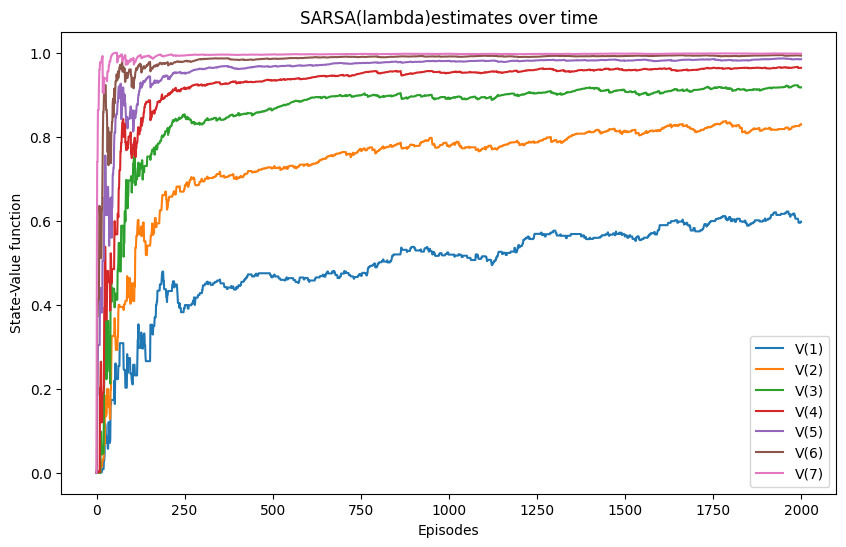

In [11]:
import matplotlib.pyplot as plt

legends = ['V(1)','V(2)','V(3)','V(4)','V(5)', 'V(6)', 'V(7)']

plt.figure(figsize=(10,6))

plt.plot(V_track_sarsa_lambda[:,1:8])
plt.title('SARSA(lambda)estimates over time')
plt.ylabel('State-Value function')
plt.xlabel('Episodes')
plt.legend(legends)

plt.show()